# Image Colorization

### Dataset
- Kaggle : https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset

# 1. Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/DL_project/
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/DL_project
/content/drive/MyDrive/ColabNotebooks/DL_project


In [ ]:
!nvidia-smi

Sat Apr  8 13:00:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

import os
import sys
import re
import time
import requests
import pickle

from io import BytesIO
from itertools import chain
from tqdm import tqdm

from dataclasses import dataclass

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, Sequential

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, BatchNormalization, LeakyReLU, Dropout, RepeatVector, Reshape, concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

import tensorflow as tf
from tensorflow.image import ssim
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.random import set_seed

import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from skimage.util import crop  # skimage.util.pad is removed -> use numpy.pad instead
from skimage.transform import resize
from skimage.morphology import label

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
path = "/content/drive/MyDrive/ColabNotebooks/DL_project"
train_c = path + "/train_color/"
train_b = path + "/train_black/"
test_c = path + "/test_color/"
test_b = path + "/test_black/"

seed = 2453
random.seed = seed
np.random.seed = seed
set_seed(seed)
tf.random.set_seed(seed)

# height, width
H = 224
W = 224

# 2. Data Preprocessing

### 1) Image Manipulation : LAB
- Opencv reads the image in BGR format
- we need to convert the image to RGB format first before turning it to greyscale with opencv

In [ ]:
def imgLAB(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR (openCV) -> RGB (ML, Computer vision)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # RGB -> Gray : remove color info, keep only the intensity info
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Gray -> RGB : duplicate the intensity values = still gray

    return img

### 2) Split Multiple Images into L & AB channels at once
- method1 : use `cvtColor`
- method2 : use `rgb2lab`

In [ ]:
def ExtractLAB1(path):
    L = []
    AB = []
    for img in os.listdir(path):
        try:
            img = imgLAB(path+img)
            img = img.astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)  # Lab : L (lightness), a (green-red), and b (blue-yellow)
            img = cv2.resize(img, (W, H)) # resize

            img_L = img[:,:,0]       # L channel
            img_ab = img[:,:,1:]/128 # ab channel : -128 ~ +128 -> -1 ~ +1

            L.append(img_L)
            AB.append(img_ab)

        except:
            pass
    
    L = np.array(L)
    AB = np.array(AB)

    return L, AB

def ExtractLAB2(imgs):
    L = []
    AB = []
    for img in imgs:
        try:
            img = rgb2lab(img)

            img_L = img[:,:,0]       # L channel
            img_ab = img[:,:,1:]/128 # ab channel : -128 ~ +128 -> -1 ~ +1

            L.append(img_L)
            AB.append(img_ab)

        except:
            pass
    
    L = np.array(L)
    AB = np.array(AB)

    return L, AB

# 3-1. Modeling : Basic CNN1
- Most Basic Colorizing Neural Network Model

### Code Reference
- Kaggle : https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn
- Reading 1 : https://www.freecodecamp.org/news/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d
- Reading 2 : https://learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/

### Idea
- Use the most **basic auto-encoder** for image colorization
- Turn the RGB image into LAB image
  - then separate the L value and ab value from the image
    - L value : lightness
    - ab value : color spectra green-red and blue-yellow
  - then train the model to predict the ab value

### Conclusion
- The Model is able to **identify the correct pattern or shades** in which the color must be filled
- The model is able to **separate out** the portions which is needed to be colored to get the colorized image
- However, it is not able to predict the accurate color for that shade or portion all the time with respect to the ground truth image

### Future work
- Feature extraction with ResNet
- GAN
- other image colorization techniques

In [ ]:
# Setting
conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=conf)
K.set_session(session)

# Kaggle code's original pic
# train_c = path + "/BasicCNN1_Pics/training_set/painting/"

# Data Preprocessing
L, AB = ExtractLAB1(train_c)
print(L.shape)
print(AB.shape)

(5000, 224, 224)
(5000, 224, 224, 2)


In [ ]:
K.clear_session()

# Modeling
def basicCNN(input):
    x = Conv2D(16,(3,3),padding="same",strides=1)(input) ###

    x = Conv2D(128,(3,3),padding="same",strides=1)(input) # 16
    x = LeakyReLU()(x)
    x = Conv2D(128,(3,3),padding="same",strides=1)(x) # 32
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding="same")(x)

    x = Conv2D(64,(3,3),padding="same",strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2),padding="same")(x)

    x = Conv2D(128,(3,3),padding="same",strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(256,(3,3),padding="same",strides=1)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    # UpSampling2D : doubling its spatial dimensions along both the height and width dimension
    x = UpSampling2D((2,2))(x)
    x = Conv2D(512,(3,3),padding="same",strides=1)(x) # 128
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2,2))(x)
    x = Conv2D(256,(3,3),padding="same",strides=1)(x) # 64
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = concatenate([x, input])

    x = Conv2D(128,(3,3),padding="same",strides=1)(x) # 64
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(32,(3,3),padding="same",strides=1)(x) # 32
    x = LeakyReLU()(x)

    x = Conv2D(2,(3,3),activation="tanh",padding="same",strides=1)(x)
    
    return x

### Compile : colorization

In [ ]:
lr = 0.001

input = Input(shape=(H,W,1))
output = basicCNN(input)
model = Model(inputs=input, outputs=output)

model.compile(
    optimizer=Adam(lr=lr),
    loss="mse",
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 12  1280        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 224, 224, 12  0           ['conv2d_1[0][0]']               
                                8)                                                            

### Training

In [ ]:
def batchInput(L, AB):
    
    for i in range(len(L)):
        # 4D tensor : (batch_size, height, width, channels)
        # channels : Lab color space
        L_input = L[i].reshape(1,224,224,1)     # 1 : L channel
        AB_input = AB[i].reshape(1,224,224,2) # 2 : AB channels

        # tuple : a batch of input data and corresponding labels
        # A batch of input data : a subset of the training data that is processed together during a single training iteration
        yield (L_input, AB_input)

In [ ]:
# Load model
# model = tf.keras.models.load_model(path+'/Basic-CNN1.h5')

In [ ]:
model.fit(
    batchInput(L, AB),
    epochs=100,         # the number of times to iterate over the entire training dataset
    verbose=1,          # controls the amount of logging output (0: no output, 1: print progress bar + brief summary, 2: only summary)
    steps_per_epoch=50, # the number of batches to yield from the generator in one epoch
    shuffle=True,       # whether to shuffle training dataset in each epoch
)

Epoch 1/100
50/50 [==============================] - 24s 97ms/step - loss: 0.1318 - accuracy: 0.5548
Epoch 2/100
50/50 [==============================] - 5s 98ms/step - loss: 0.0327 - accuracy: 0.5989
Epoch 3/100
50/50 [==============================] - 5s 99ms/step - loss: 0.0225 - accuracy: 0.4479
Epoch 4/100
50/50 [==============================] - 5s 99ms/step - loss: 0.0176 - accuracy: 0.4275
Epoch 5/100
50/50 [==============================] - 5s 100ms/step - loss: 0.0157 - accuracy: 0.6250
Epoch 6/100
50/50 [==============================] - 5s 101ms/step - loss: 0.0158 - accuracy: 0.4133
Epoch 7/100
50/50 [==============================] - 5s 101ms/step - loss: 0.0136 - accuracy: 0.5123
Epoch 8/100
50/50 [==============================] - 5s 102ms/step - loss: 0.0136 - accuracy: 0.5697
Epoch 9/100
50/50 [==============================] - 5s 103ms/step - loss: 0.0133 - accuracy: 0.4941
Epoch 10/100
50/50 [==============================] - 5s 103ms/step - loss: 0.0127 - accuracy:

### Evaluation

In [ ]:
def ExtractTestLAB(img):
    img = imgLAB(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img = img.astype(np.float32)
    img = cv2.resize(img, (W,H))

    L = img[:,:,0]       # L channel
    L = L.reshape(1,224,224,1)

    AB = img[:,:,1:]/128 # ab channel : -128 ~ +128 -> -1 ~ +1
    
    return L, AB

def Compare(img_p):
    
    test_L, _ = ExtractTestLAB(img_p)

    pred = model.predict(test_L) * 128
    pred = pred.reshape(224,224,2)

    img = cv2.imread(img_p)    

    plt.figure(figsize=(10,10))

    plt.subplot(3,3,1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    gray = cv2.resize(gray, (224,224))
    plt.title("Grayscale")
    plt.imshow(gray)

    plt.subplot(3,3,2)
    true = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("Ground Truth")
    plt.imshow(true)

    plt.subplot(3,3,3)
    plt.title("Predict")
    img_pred = cv2.cvtColor(gray, cv2.COLOR_RGB2Lab)
    img_pred[:,:,1:] = pred
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_Lab2RGB)
    plt.imshow(img_pred)   

1/1 [==============================] - 0s 19ms/step


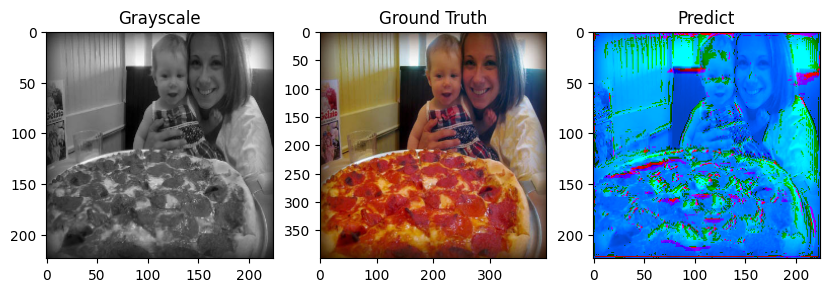

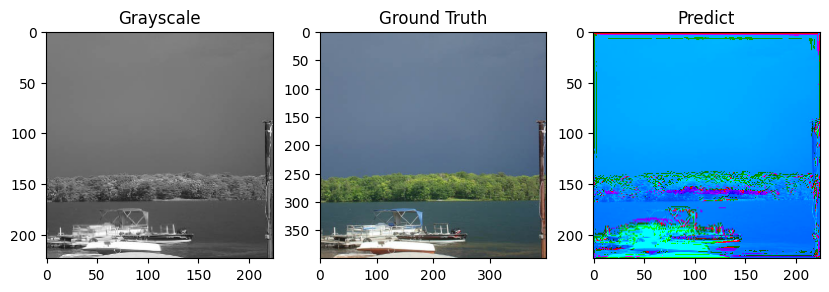

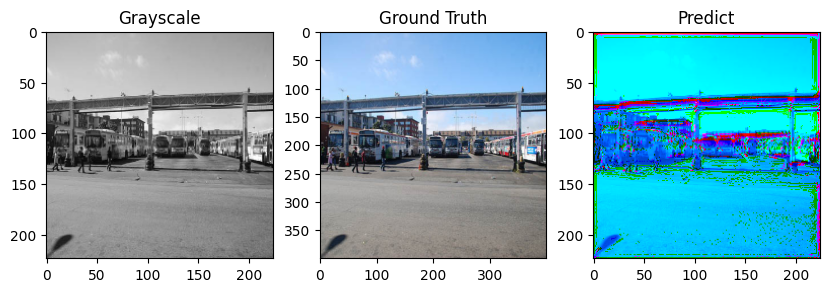

In [ ]:
# My dataset
pics = ["image5005.jpg", "image5050.jpg", "image5089.jpg"]

for p in pics:
    img_p = test_c + p
    Compare(img_p)

### Save Model

In [ ]:
# model.save(path+'/Basic-CNN1.h5')

# 3-2. Modeling : Basic CNN2

### Code Reference
- Kaggle : https://www.kaggle.com/code/mertbozkurt5/basic-image-colorization
  - I used original input to train the model (Otherwise, the performance is bad)

### Conclusion
- The model's performance is better than Basic CNN1
- I saved the model that showed more than 0.90 acc in the training set 

In [ ]:
# define the augmentation and preprocessing parameters
train_dg = ImageDataGenerator(rescale=1./255,)

# load the training data and apply the augmentation and preprocessing
train = train_dg.flow_from_directory(
    path + "/Pix2PixGAN_Pics/landscape/train/", ## original Kaggle dataset
    # path + "/train/", ## upper directory
    target_size=(256, 256),
    batch_size=128,  # 32
    # batch_size=1000,
    class_mode=None
)

Found 7129 images belonging to 1 classes.


### Data Preprocessing

`ExtractLAB(train[0])`
- Extract the L and AB channels from the images in the first batch of the train generator
- So if there are more than 1st batch_size images in the training set, only a subset of the training data will be used to extract the L and AB channels

In [ ]:
L, AB = ExtractLAB2(train[0])

In [ ]:
print(L.shape, AB.shape)

(128, 256, 256) (128, 256, 256, 2)


### Modeling

- Encoder
  - the convolutional layers with strides=2 and MaxPooling2D layer with pool_size=(2, 2) reduce the spatial dimensions of the input feature maps
- Decoder
  - the convolutional layers with UpSampling2D layer with size=(2, 2) and Conv2DTranspose layers increase the spatial dimensions of the input feature maps

In [ ]:
### Original Code
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same')) ###
# model.add(Conv2D(128, (3,3), activation='relu', padding='same')) ###
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

# Compile
model.compile(
    # optimizer='adam',
    optimizer=Adam(lr=1e-3),
    loss='mse' ,
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 256)     147712    
                                                                 
 dropout_9 (Dropout)         (None, 128, 128, 256)     0         
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 128)       295040    
                                                                 
 dropout_10 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 256)       295168    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 256)      

### Training

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model.fit(
    L,
    AB,
    validation_split=0.2,
    epochs=500,
    batch_size=512, # 512
    # callbacks=[early_stop]
)

Epoch 1/500
1/1 [==============================] - 46s 46s/step - loss: 0.0467 - accuracy: 0.5020 - val_loss: 0.1209 - val_accuracy: 0.4376
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 0.2899 - accuracy: 0.5086 - val_loss: 0.0101 - val_accuracy: 0.4091
Epoch 3/500
1/1 [==============================] - 2s 2s/step - loss: 0.0132 - accuracy: 0.5221 - val_loss: 0.0100 - val_accuracy: 0.4084
Epoch 4/500
1/1 [==============================] - 2s 2s/step - loss: 0.0133 - accuracy: 0.5248 - val_loss: 0.0100 - val_accuracy: 0.4084
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 0.0135 - accuracy: 0.5246 - val_loss: 0.0100 - val_accuracy: 0.4084
Epoch 6/500
1/1 [==============================] - 2s 2s/step - loss: 0.0135 - accuracy: 0.5250 - val_loss: 0.0100 - val_accuracy: 0.4084
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 0.0135 - accuracy: 0.5269 - val_loss: 0.0100 - val_accuracy: 0.4084
Epoch 8/500
1/1 [===============

### Evaluation

In [ ]:
# Load model
# model = tf.keras.models.load_model(path+'/Basic-CNN2.h5')

1/1 [==============================] - 0s 18ms/step


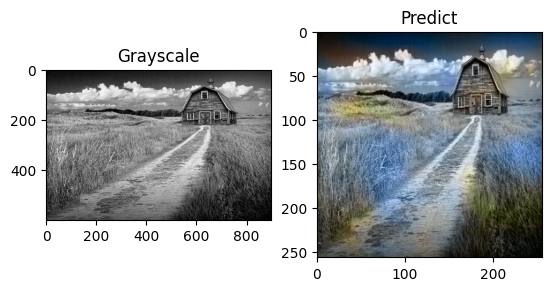

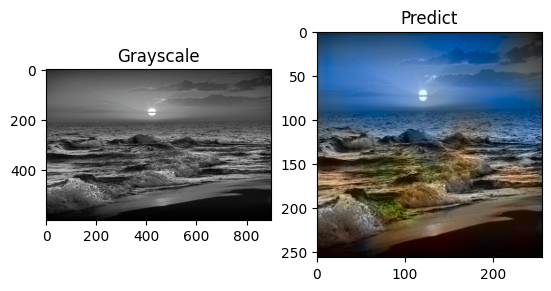

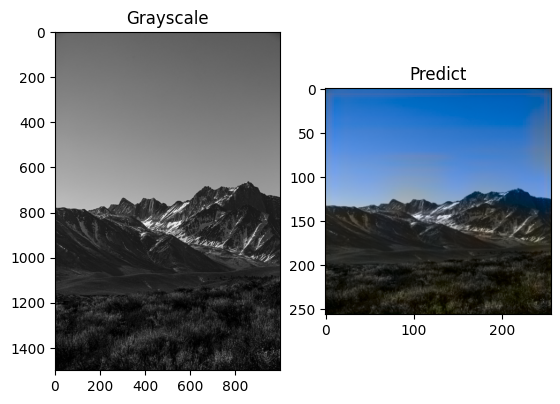

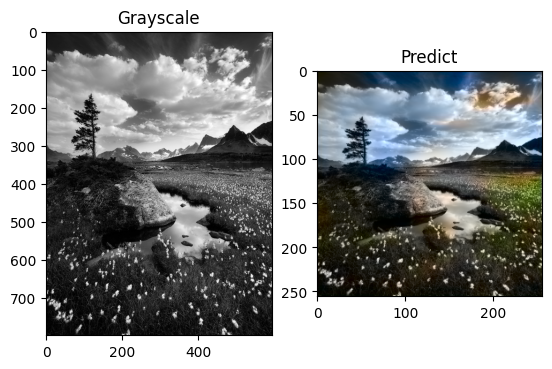

In [ ]:
# Original test
from PIL import Image
import requests
from io import BytesIO

url1 = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/old-barn-in-black-and-white-randall-nyhof.jpg'
url2 = 'https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/horizontal-black-and-white-photograph-of-a-lake-michigan-sunset-randall-nyhof.jpg'
url3 = 'https://images.unsplash.com/photo-1614925861087-aa06270091b3?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8OXx8YmxhY2slMjBhbmQlMjB3aGl0ZSUyMG5hdHVyZXxlbnwwfHwwfHw%3D&w=1000&q=80'
url4 = 'https://images.squarespace-cdn.com/content/538a3874e4b0ab1541d204ad/1490210210601-DDAMF95MFG8RQ7T1M56V/?content-type=image%2Fjpeg'

urls = [url1, url2, url3, url4]

for i in range(0, 4):

    res = requests.get(urls[i]) # response

    img_org = Image.open(BytesIO(res.content))
    img = img_to_array(img_org)
    img = resize(img, (256, 256))

    img_c = []
    img_c.append(img)
    img_c = np.array(img_c, dtype=float)
    img_c = rgb2lab(1./255 * img_c)[:,:,:,0]
    img_c = img_c.reshape(img_c.shape+(1,))

    pred = model.predict(img_c)
    pred = pred * 128

    out = np.zeros((256, 256, 3))
    out[:,:,0] = img_c[0][:,:,0]
    out[:,:,1:] = pred[0]
    out = lab2rgb(out)

    f, ax = plt.subplots(1,2)
    ax[0].title.set_text("Grayscale")
    ax[1].title.set_text("Predict")
    ax[0].imshow(img_org)
    ax[1].imshow(out)

1/1 [==============================] - 0s 19ms/step


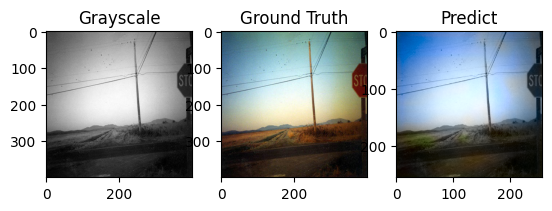

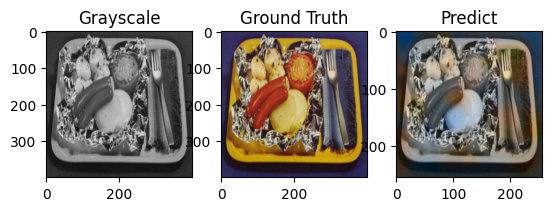

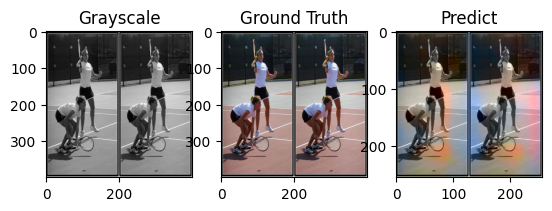

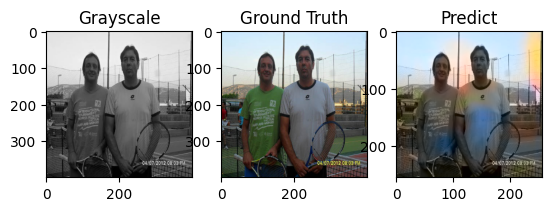

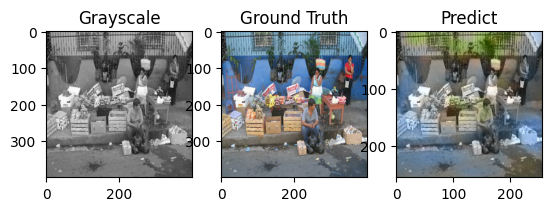

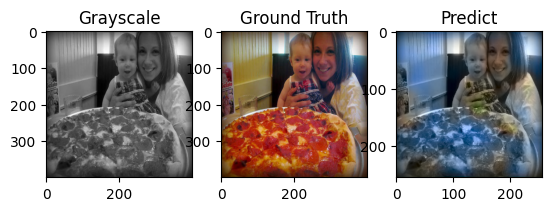

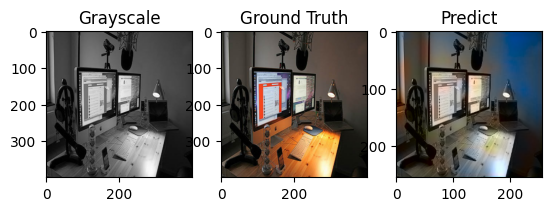

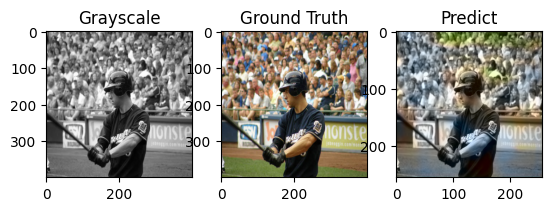

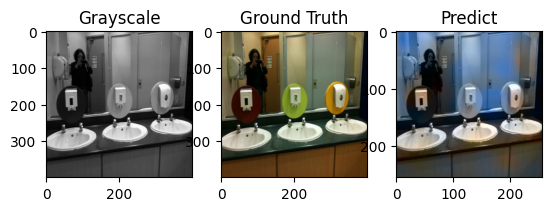

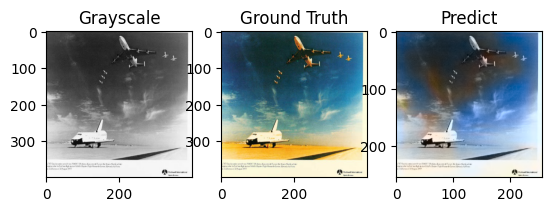

In [ ]:
for i in range(0,10):

    img_c = test_c + "image500" + str(i) + ".jpg"
    img_b = test_b + "image500" + str(i) + ".jpg"

    img_c = Image.open(img_c)
    img_b = Image.open(img_b)

    imgs = []

    img_org = img_to_array(img_b)          # (400, 400, 3)
    img_org = resize(img_org, (256,256)) # (256, 256, 3)
    imgs.append(img_org)

    # RGB -> Lab
    imgs = np.array(imgs, dtype=float)
    imgs = rgb2lab(1./255 * imgs)  # (1, 256, 256, 3) : batch, height, width, channels (L, a, b)
    imgs = imgs[:,:,:,0]
    imgs = imgs.reshape(imgs.shape + (1,)) # (1, 256, 256) + (1,) = (1, 256, 256, 1) : batch, height, width, channels (add dimension)

    ab_ch = model.predict(imgs)
    ab_ch = ab_ch * 128 # scale : [-1, 1] -> [-128, 128]

    pred         = np.zeros((256, 256, 3))
    pred[:,:,0]  = imgs[0][:,:,0] # L channel
    pred[:,:,1:] = ab_ch[0]       # ab channel

    f, ax = plt.subplots(1,3)
    ax[0].title.set_text("Grayscale")
    ax[1].title.set_text("Ground Truth")
    ax[2].title.set_text("Predict")
    ax[0].imshow(img_b)
    ax[1].imshow(img_c)
    ax[2].imshow(lab2rgb(pred))

In [ ]:
# loss = model.evaluation(L, AB)

### Save Model

In [ ]:
# model.save(path+'/Basic-CNN2.h5')

# 3-3. Modeling : Autoencoders and Resnet

### Code Reference
- Kaggle : https://www.kaggle.com/code/valkling/image-colorization-using-autoencoders-and-resnet

### Pretrained ResNet model weights
- Kaggle : https://www.kaggle.com/datasets/valkling/inception-resnet-v2-weights/code

### Idea
- ResNet might be pre-trained on 1.2 million images

### Conclusion
- The results are not bad, but mostly brownish 

### Future work
- The writer of the original article admits that he had to cherry pick the results to get a good sample from his testing set
  - Most of his results turned out brownish as well

### Data Preprocessing

100%|██████████| 2129/2129 [01:27<00:00, 24.27it/s]


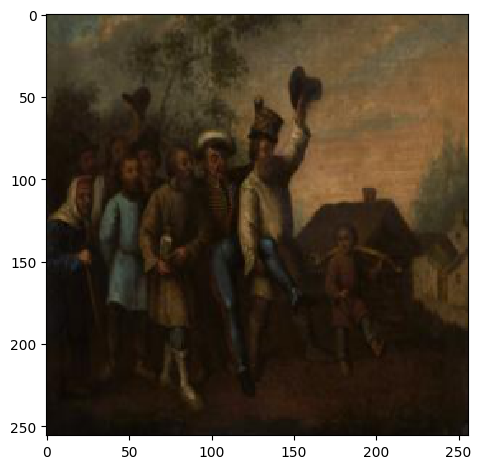

In [ ]:
H, W = 256, 256

# Kaggle code's original pic
train_c = path + "/BasicCNN1_Pics/training_set/painting/"

train_idx = next(os.walk(train_c))[2] # (dirpath, dirnames, filenames)
train_img = np.zeros((len(train_idx), H, W, 3), dtype=np.uint8)

for n, idx in tqdm(enumerate(train_idx), total=len(train_idx)): # progress bar
    img_path = train_c + idx + ''
    try:
        img = imread(img_path)
        img = resize(img, (H, W), mode='constant', preserve_range=True)
        train_img[n] = img
    except:
        pass

train_img = train_img.astype('float32') / 255.

imshow(train_img[2])
plt.show()

In [ ]:
train_img.shape

(2129, 256, 256, 3)

### Modeling

- Autoencoder + ResNet
- uses an **resnet** classifier to give the neural network an idea of what things should be colored
- We loads weights of pretrained ResNet model

In [ ]:
p_weight = path + "/pretrained_weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5"
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights(p_weight)

0.6497 ACC

In [ ]:
# Try to build something else
def AutoRes():
    emb_input = Input(shape=(1000,))
        
    # Encoder
    input = Input(shape=(H, W, 1,))
    out = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(input)
    out = MaxPooling2D((2, 2), padding='same')(out)
    out = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(out)
    out = MaxPooling2D((2, 2), padding='same')(out)
    out = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(out)
    out = MaxPooling2D((2, 2), padding='same')(out)
    out = Conv2D(256, (3,3), activation='relu', padding='same')(out)
    
    # Fusion : combine : encoder + additional info (improve model's performance)
    f_out = RepeatVector(32 * 32)(emb_input) 
    f_out = Reshape(([32, 32, 1000]))(f_out)
   
    out = concatenate([out, f_out], axis=3) 
    out = Conv2D(256, (1, 1), activation='relu', padding='same')(out)
    
    # Decoder
    out = Conv2D(128, (3,3), activation='relu', padding='same')(out)
    out = Conv2D(64, (3,3), activation='relu', padding='same')(out)
    out = UpSampling2D((2, 2))(out)
    out = Conv2D(128, (3,3), activation='relu', padding='same')(out)
    out = UpSampling2D((2, 2))(out)
    out = Conv2D(32, (2,2), activation='relu', padding='same')(out)
    out = Conv2D(2, (3, 3), activation='tanh', padding='same')(out)
    out = UpSampling2D((2, 2))(out)

    model = Model(inputs=[input, emb_input], outputs=out)

    return model

In [ ]:
model = AutoRes()

# def ssim_loss(y_true, y_pred):
#     return -ssim(y_true, y_pred, max_val=1.0)

model.compile(
    optimizer="adam",
    # optimizer=Adam(learning_rate=0.001),
    loss='mse',
    # loss = ssim_loss, # -> acc goes down
    metrics=['mse', 'mae', 'accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 256, 256, 12  1280        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 12  0          ['conv2d_203[0][0]']             
                                8)                                                            

In [ ]:
%%time
# Image transformer
train_dg = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

# Embedding
def Embed(grayRGB):

    def newX(x):
        x = resize(x, (299, 299, 3), mode='constant')
        return x

    out = np.array([newX(x) for x in grayRGB])
    out = preprocess_input(out)
    out = inception.predict(out)
    return out

# Generate training dataset
def Extract(data=train_img, batch=20):

    for img in train_dg.flow(data, batch_size=batch):
        
        gray = rgb2gray(img)
        gray = gray2rgb(gray)

        lab = rgb2lab(img)

        L = lab[:,:,:,0]
        L = L.reshape(L.shape+(1,))

        AB = lab[:,:,:,1:]/128

        yield [L, Embed(gray)], AB

CPU times: user 32 µs, sys: 2 µs, total: 34 µs
Wall time: 39.3 µs


In [ ]:
# dynamically adjust the learning rate during training based on the validation loss
lr_rule = ReduceLROnPlateau(
    monitor='loss',
    patience=3,
    # verbose=1,
    factor=0.5,
    min_lr=1e-5
)

chk = ModelCheckpoint(
    path+'/AutoRes.h5',
    save_best_only=True,
    monitor='loss',
    mode='min'
)

callbacks = [lr_rule, chk]

In [ ]:
# Kaggle's Original Code -> split
train_img, test_img = train_test_split(train_img, test_size=20, random_state=seed)

In [ ]:
batch = 20

model.fit(
    Extract(train_img, batch),
    epochs=15, # original : 30 -> but, memory issue
    verbose=1,
    steps_per_epoch=train_img.shape[0]/batch,
    callbacks=callbacks
)

1/1 [==============================] - 13s 13s/step
Epoch 1/15
105/105 [==============================] - 138s 1s/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0538 - accuracy: 0.8211 - lr: 0.0010
Epoch 2/15
105/105 [==============================] - 122s 1s/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0457 - accuracy: 0.8343 - lr: 0.0010
Epoch 3/15
105/105 [==============================] - 123s 1s/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0440 - accuracy: 0.8355 - lr: 0.0010
Epoch 4/15
105/105 [==============================] - 124s 1s/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0430 - accuracy: 0.8522 - lr: 0.0010
Epoch 5/15
105/105 [==============================] - 124s 1s/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0425 - accuracy: 0.8508 - lr: 0.0010
Epoch 6/15
105/105 [==============================] - 124s 1s/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0425 - accuracy: 0.8460 - lr: 0.0010
Epoch 7/15
105/105 [==============================] - 123s 1s/step - loss: 0.0042 - mse: 0.0042 

### Evaluation

In [ ]:
test = rgb2gray(test_img)
test = gray2rgb(test)
test = rgb2lab(test)[:,:,:,0]
test = test.reshape(test.shape+(1,))

test_emb = Embed(test)

pred = model.predict([test, test_emb])
pred = pred * 128 # -1 ~ +1 -> -128 ~ +128

cnt = len(pred)
# cnt = 50
out = np.zeros((cnt, 256, 256, 3))

for idx in range(cnt):
    rst = np.zeros((256, 256, 3))
    rst[:,:,0] = test[idx][:,:,0]
    rst[:,:,1:] = pred[idx]
    out[idx] = lab2rgb(rst)

1/1 [==============================] - 0s 132ms/step


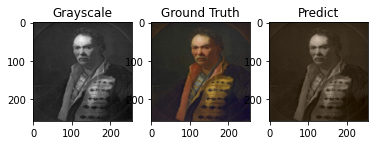

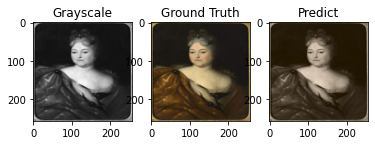

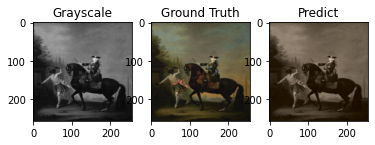

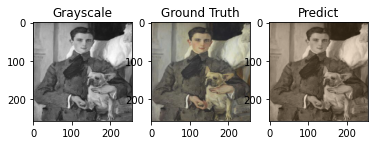

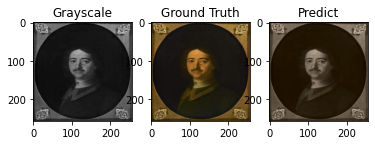

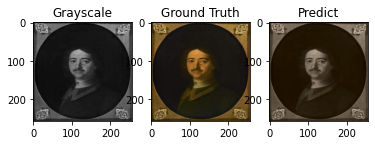

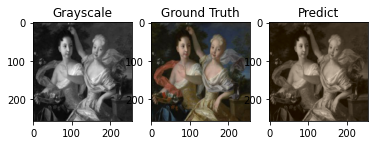

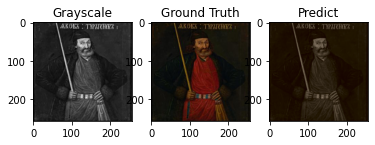

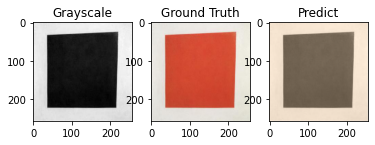

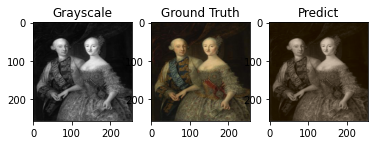

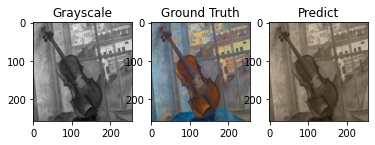

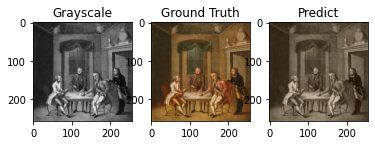

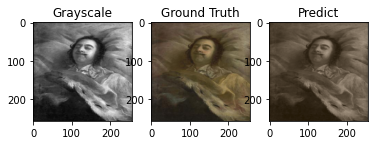

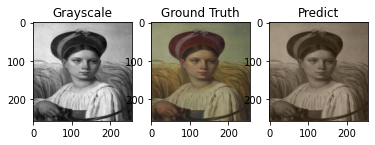

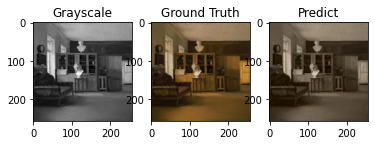

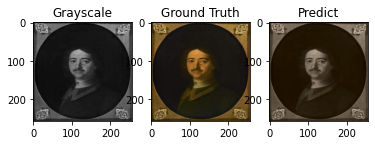

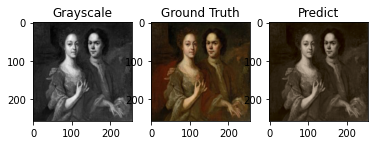

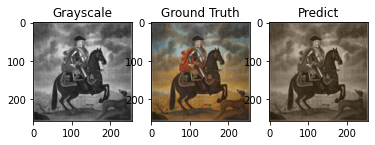

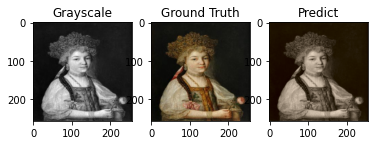

In [ ]:
# plt.figure(figsize=(30, 60))
for i in range(1, cnt):

    img_b = rgb2gray(test_img)[i].reshape(256, 256)
    img_c = test_img[i].reshape(256, 256, 3)
    pred = out[i].reshape(256,256,3)

    f, ax = plt.subplots(1,3)
    ax[0].title.set_text("Grayscale")
    ax[1].title.set_text("Ground Truth")
    ax[2].title.set_text("Predict")
    ax[0].imshow(img_b, cmap='gray')
    ax[1].imshow(img_c)
    ax[2].imshow(pred)

### Save Model

In [ ]:
model.save(path+'/AutoRes.h5')
model.save_weights(path+'/AutoRes_weights.h5')

In [ ]:
# Load model
# model = tf.keras.models.load_model(path+'/AutoRes.h5')

# 3-4. Modeling : Pix2Pix GAN

### Code Reference
- Kaggle 1 : https://www.kaggle.com/code/theblackmamba31/pix2pix-gan-coloring-images
- Kaggle 2 : https://www.kaggle.com/code/orkatz2/pytorch-pix-2-pix-for-image-colorization


 31%|███       | 2200/7129 [02:12<04:57, 16.54it/s] 


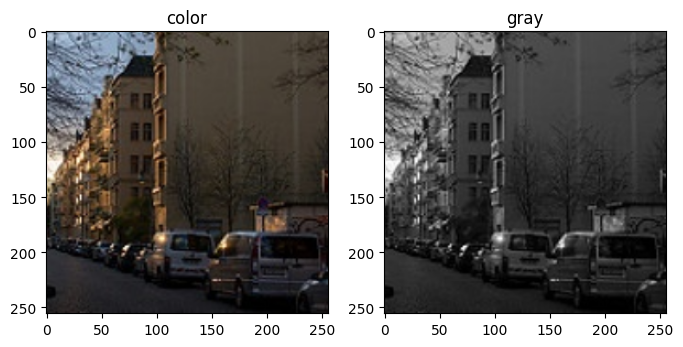

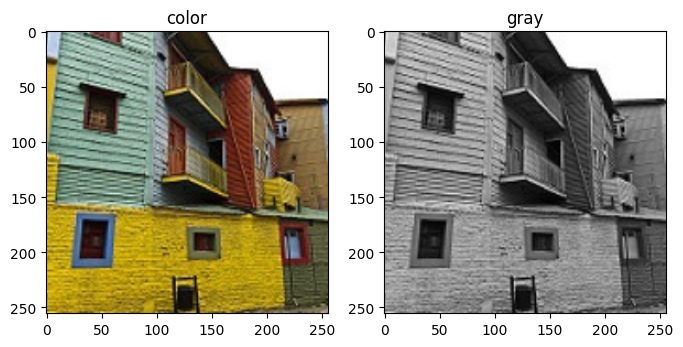

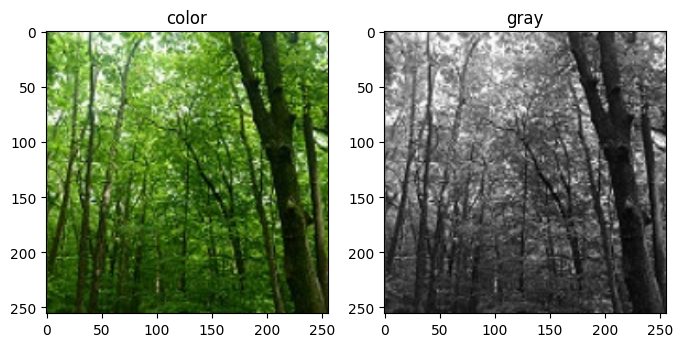

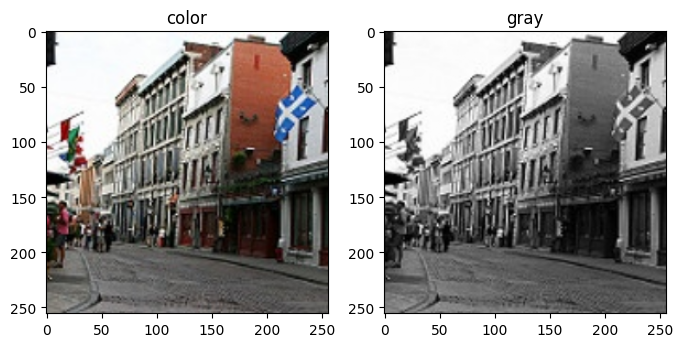

In [ ]:
H, W = 256, 256

def sortImages(data):
    rule1 = lambda text: int(text) if text.isdigit() else text.lower()
    rule2 = lambda key: [rule1(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=rule2)
    
def imgArray(path, H=256, W=256):
    files = os.listdir(path)
    files = sortImages(files)

    imgs = []
    
    for i, img_name in tqdm(enumerate(files), total = len(files)):
        if i == 2200:
            break
        img = cv2.imread(path + img_name, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (H, W))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)        
        imgs.append(img)
    
    return imgs

train_c = path + "/Pix2PixGAN_Pics/landscape/train/color/"
train_b = path + "/Pix2PixGAN_Pics/landscape/gray/"

imgs_c = imgArray(train_c)
imgs_b = imgArray(train_b)

data_c = tf.data.Dataset.from_tensor_slices(np.array(imgs_c[:2000])).batch(64)
data_b = tf.data.Dataset.from_tensor_slices(np.array(imgs_b[:2000])).batch(64)

data_c_t = tf.data.Dataset.from_tensor_slices(np.array(imgs_c[2000:])).batch(8)
data_b_t = tf.data.Dataset.from_tensor_slices(np.array(imgs_b[2000:])).batch(8)

ex_c = next(iter(data_c))
ex_b = next(iter(data_b))

for i in range(4):
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.title('color')
    plt.imshow(ex_c[i])

    plt.subplot(122)
    plt.title('gray')
    plt.imshow(ex_b[i])

    plt.show()

### Modeling

In [ ]:
# DownSample
def dSample(f_num, f_size, batchNorm=True):
  
  model = tf.keras.Sequential()
  model.add(
      tf.keras.layers.Conv2D(f_num, f_size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
      )

  if batchNorm:
      model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.LeakyReLU())

  return model

# UpSample
def uSample(f_num, f_size, dropout=False):
    
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2DTranspose(f_num, f_size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)
        )

    model.add(tf.keras.layers.BatchNormalization())

    if dropout:
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.ReLU())

    return model

In [ ]:
def Generator():

    input = tf.keras.layers.Input(shape=[256,256,3])

    # mean, sd -> typical GAN initializer
    init = tf.random_normal_initializer(0.,0.02)

    dStack = [
        dSample(64, 4, False),
        dSample(128, 4),
        dSample(256, 4),
        dSample(512, 4),
        dSample(512, 4),
        dSample(512, 4),
        dSample(512, 4),
        dSample(512, 4),
    ]

    uStack = [
        uSample(512, 4, True),
        uSample(512, 4, True),
        uSample(512, 4, True),
        uSample(512, 4),
        uSample(256, 4),
        uSample(128, 4),
        uSample(64, 4),
    ]

    out = input

    ### Downsampling through the model
    # skip : prevent vanishing gradient in DNN
    skip = []

    for d in dStack:
        out = d(out)
        skip.append(out)

    skip = reversed(skip[:-1])

    ### Upsampling and establishing the skip connections
    for u, s in zip(uStack, skip):
        out = u(out)
        out = tf.keras.layers.Concatenate()([out, s])

    out = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding="same", kernel_initializer=init, activation='tanh')(out)

    return tf.keras.Model(inputs=input, outputs=out)

### Build
gen = Generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

In [ ]:
def Discriminator():

    init = tf.random_normal_initializer(0.,0.02)

    input = tf.keras.layers.Input(shape=[256,256,3], name="input")
    target = tf.keras.layers.Input(shape=[256,256,3], name="target")

    out = tf.keras.layers.concatenate([input, target]) # batch, H, W, ch*2

    out = dSample(64, 4, False)(out) # batch, 128, 128, 64
    out = dSample(128, 4)(out) # batch, 64, 64, 128
    out = dSample(256, 4)(out) # batch, 32, 32, 256

    out = tf.keras.layers.ZeroPadding2D()(out) # batch, 34, 34, 256
    out = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(out) # batch, 31, 31, 512
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.LeakyReLU()(out)
    out = tf.keras.layers.ZeroPadding2D()(out) # batch, 33, 33, 512
    out = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(out) # batch, 30, 30, 1

    return tf.keras.Model(inputs=[input, target], outputs=out)

### Build
dis = Discriminator()
dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input[0][0]',                  
                                                                  'target[0][0]']           

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
dis_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# lambda : controls the relative weight of the losses
lam = 100

# Generator loss
def gen_loss(output, pred, true):

    # first calculates the binary cross-entropy loss
    # between a vector of ones and the generated output
    # -> encourages the generator to produce realistic outputs
    ce_loss = loss(tf.ones_like(output), output)

    # MAE : mean absolute error
    # between the generated output and the true output
    mae = tf.reduce_mean(tf.abs(true - pred))

    tot_loss = ce_loss + (lam * mae)

    return tot_loss, ce_loss, mae

# Discriminator loss
def dis_loss(true, pred):

    # calculates the binary cross-entropy loss
    # between a vector of ones and the true output
    # -> encourages the discriminator to correctly classify real inputs
    loss1 = loss(tf.ones_like(true), true)

    # calculates the binary cross-entropy loss
    # between a vector of zeros and the generated output
    # -> encourages the discriminator to correctly classify fake inputs
    loss2 = loss(tf.zeros_like(pred), pred)

    return loss1 + loss2

### Training

In [ ]:
def Train(input, target, epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        
        # g : generator
        # d : discriminator
        g_out = gen(input, training=True)

        d_real = dis([input, target], training=True)
        d_gen = dis([input, g_out], training=True) # generated output

        g_loss, ce_loss, mae = gen_loss(d_gen, g_out, target)
        d_loss = dis_loss(d_real, d_gen)

    # gradients
    # derivative of g_loss/d_loss w.r.t. trainable_variables
    g_grad = g_tape.gradient(g_loss, gen.trainable_variables)
    d_grad = d_tape.gradient(d_loss, dis.trainable_variables)

    gen_opt.apply_gradients(zip(g_grad, gen.trainable_variables))
    dis_opt.apply_gradients(zip(d_grad, dis.trainable_variables))

In [ ]:
def modelFit(train, epochs, ):
    for e in range(epochs):
        s = time.time()
        print("Epoch: ", e+1)

        # Train
        for n, (input, target) in train.enumerate():
            Train(input, target, e)
        print()
        print("Time taken for epoch {} is {} sec".format(e+1, time.time() - s))

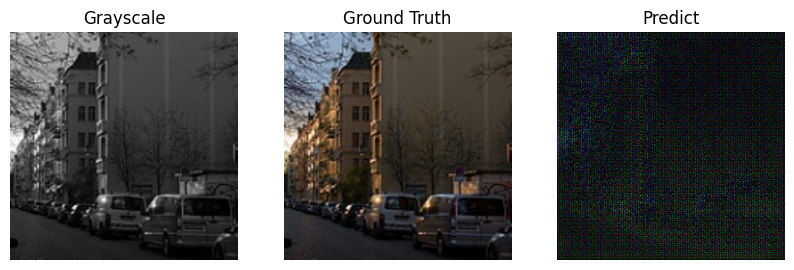

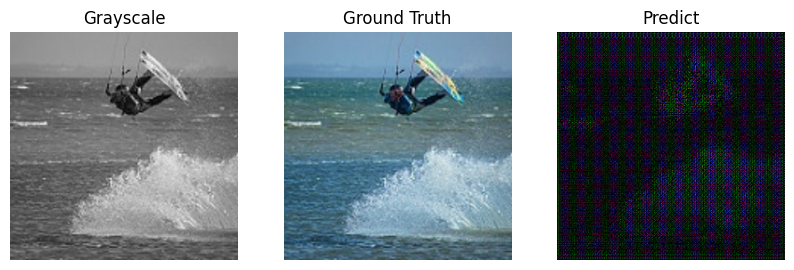

In [ ]:
def genImages(model, test, target):
    pred = model(test, training=True)
    
    plt.figure(figsize=(10,10))

    pics = [test[0], target[0], pred[0]]
    title = ["Grayscale", "Ground Truth", "Predict"]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(pics[i])
        plt.axis('off')

    plt.show()

# take(n) : take the first n elements -> reduce memory
for input, target in tf.data.Dataset.zip((data_b, data_c)).take(2):
    genImages(gen, input, target)

In [ ]:
# Load model
# gen = tf.keras.models.load_model(path+'/Pix2PixGAN.h5')

In [ ]:
modelFit(tf.data.Dataset.zip((data_b, data_c)), epochs = 10)

Epoch:  1



Time taken for epoch 1 is 110.64022088050842 sec
Epoch:  2

Time taken for epoch 2 is 89.70950627326965 sec
Epoch:  3

Time taken for epoch 3 is 89.79015851020813 sec
Epoch:  4

Time taken for epoch 4 is 89.54457974433899 sec
Epoch:  5

Time taken for epoch 5 is 89.37506699562073 sec
Epoch:  6

Time taken for epoch 6 is 89.38821196556091 sec
Epoch:  7

Time taken for epoch 7 is 89.44344234466553 sec
Epoch:  8

Time taken for epoch 8 is 89.43848776817322 sec
Epoch:  9

Time taken for epoch 9 is 89.462881565094 sec
Epoch:  10

Time taken for epoch 10 is 89.64359021186829 sec


In [ ]:
# take(n) : take the first n elements -> reduce memory
for input, target in tf.data.Dataset.zip((data_b, data_c)).take(15):
    genImages(gen, input, target)

Output hidden; open in https://colab.research.google.com to view.

### Save Model

In [ ]:
# gen.save(path+'/Pix2PixGAN.h5')
# gen.save_weights(path+'/Pix2PixGAN_weights.h5')

# 4. Evaluation

In [ ]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import lpips
from scipy import linalg

import torch
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from skimage.metrics import structural_similarity as ssim

basicCNN1 = tf.keras.models.load_model(path+'/models/Basic-CNN1.h5')
basicCNN2 = tf.keras.models.load_model(path+'/models/Basic-CNN2.h5')
autoRes = tf.keras.models.load_model(path+'/models/AutoRes.h5')
gan = tf.keras.models.load_model(path+'/models/Pix2PixGAN.h5')

In [ ]:
testfiles = []
testfiles_p = []

for i in range(5000, 5739):
    name = "image" + str(i) + ".jpg"
    p = test_c + name
    testfiles.append(name)
    testfiles_p.append(p)

# testfiles
print(testfiles_p[0])

###

testfiles_b = []
testfiles_b_p = []

for i in range(5000, 5739):
    name = "image" + str(i) + ".jpg"
    p = test_b + name
    testfiles_b.append(name)
    testfiles_b_p.append(p)

# testfiles
print(testfiles_b_p[0])

/content/drive/MyDrive/ColabNotebooks/DL_project/test_color/image5000.jpg
/content/drive/MyDrive/ColabNotebooks/DL_project/test_black/image5000.jpg


# 4.1 Predict
- Predict the test set images
- Convert the predicted images to a NumPy array and save them

### Vanilla CNN1

In [ ]:
def CNN1_eval(model, img_path):

    img = imgLAB(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img = img.astype(np.float32)
    img = cv2.resize(img, (W,H))

    L = img[:,:,0]       # L channel
    L = L.reshape(1,224,224,1)

    AB = img[:,:,1:]/128 # ab channel : -128 ~ +128 -> -1 ~ +1
    
    pred = model.predict(L) * 128
    pred = pred.reshape(224,224,2)

    img = cv2.imread(img_path)

    # get the gray part of the original image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    gray = cv2.resize(gray, (224,224))

    img_pred = cv2.cvtColor(gray, cv2.COLOR_RGB2Lab)
    img_pred[:,:,1:] = pred
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_Lab2RGB)
    
    # plt.imshow(img_pred)
    return img_pred # numpy array

In [ ]:
rst_CNN1 = []

for name in testfiles_p:
    rst_CNN1.append(CNN1_eval(basicCNN1, name))

1/1 [==============================] - 0s 23ms/step


In [ ]:
# with open(path+'rst_CNN1.pkl', 'wb') as f:
#     pickle.dump(rst_CNN1, f)

with open(path+'rst_CNN1.pkl', 'rb') as f:
    rst_CNN1 = pickle.load(f)

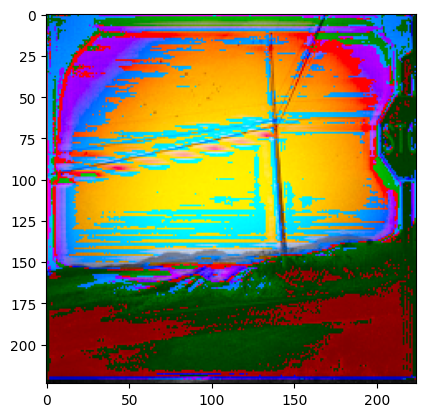

In [ ]:
plt.imshow(rst_CNN1[0])

### Vanilla CNN2

In [ ]:
def CNN2_eval(model, color_path, gray_path):

    img_c = Image.open(color_path)
    img_b = Image.open(gray_path)

    imgs = []

    img_org = img_to_array(img_b)        # (400, 400, 3)
    img_org = resize(img_org, (256,256)) # (256, 256, 3)
    imgs.append(img_org)

    # RGB -> Lab
    imgs = np.array(imgs, dtype=float)
    imgs = rgb2lab(1./255 * imgs)  # (1, 256, 256, 3) : batch, height, width, channels (L, a, b)
    imgs = imgs[:,:,:,0]
    imgs = imgs.reshape(imgs.shape + (1,)) # (1, 256, 256) + (1,) = (1, 256, 256, 1) : batch, height, width, channels (add dimension)

    ab_ch = model.predict(imgs)
    ab_ch = ab_ch * 128 # scale : [-1, 1] -> [-128, 128]

    pred         = np.zeros((256, 256, 3))
    pred[:,:,0]  = imgs[0][:,:,0] # L channel
    pred[:,:,1:] = ab_ch[0]       # ab channel

    # plt.imshow(p2)
    return lab2rgb(pred)

In [ ]:
rst_CNN2 = []

for i in range(len(testfiles_p)):
    rst_CNN2.append(CNN2_eval(basicCNN2, testfiles_p[i], testfiles_b_p[i]))

1/1 [==============================] - 0s 19ms/step


In [ ]:
# with open(path+'/rst_CNN2.pkl', 'wb') as f:
#     pickle.dump(rst_CNN2, f)

with open(path+'rst_CNN2.pkl', 'rb') as f:
    rst_CNN2 = pickle.load(f)

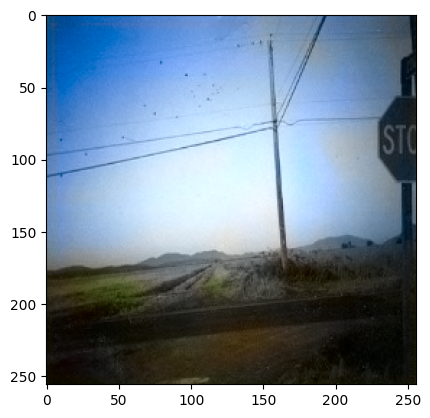

In [ ]:
plt.imshow(rst_CNN2[0])

### Autoencoders and Resnet

In [ ]:
p_weight = path + "/pretrained_weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5"
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights(p_weight)

In [ ]:
def Embed(grayRGB):

    def newX(x):
        x = resize(x, (299, 299, 3), mode='constant')
        return x

    out = np.array([newX(x) for x in grayRGB])
    out = preprocess_input(out)
    out = inception.predict(out)
    return out

def auto_eval(model, img_path, files):

    imgs = np.zeros((len(img_path), 256, 256, 3), dtype=np.uint8)

    for i, name in tqdm(enumerate(img_path), total=len(img_path)): # progress bar
        img = imread(name)
        img = resize(img, (256, 256), mode='constant', preserve_range=True)
        imgs[i] = img

    imgs = imgs.astype('float32') / 255.

    test = rgb2gray(imgs)
    test = gray2rgb(test)
    test = rgb2lab(test)[:,:,:,0]
    test = test.reshape(test.shape+(1,))

    test_emb = Embed(test)

    pred = model.predict([test, test_emb])
    pred = pred * 128 # -1 ~ +1 -> -128 ~ +128

    cnt = len(pred)
    out = np.zeros((cnt, 256, 256, 3))

    final = []

    for i in range(cnt):
        rst = np.zeros((256, 256, 3))
        rst[:,:,0] = test[i][:,:,0]
        rst[:,:,1:] = pred[i]
        out[i] = lab2rgb(rst)

        img_b = rgb2gray(imgs)[i].reshape(256, 256)
        img_c = imgs[i].reshape(256, 256, 3)
        p = out[i].reshape(256,256,3)

        final.append(p)

    return final

In [ ]:
rst_auto = auto_eval(autoRes, testfiles_p, testfiles)

100%|██████████| 739/739 [00:19<00:00, 36.97it/s]


24/24 [==============================] - 2s 79ms/step


In [ ]:
# with open(path+'/rst_auto.pkl', 'wb') as f:
#     pickle.dump(rst_auto, f)

with open(path+'/rst_auto.pkl', 'rb') as f:
    rst_auto = pickle.load(f)

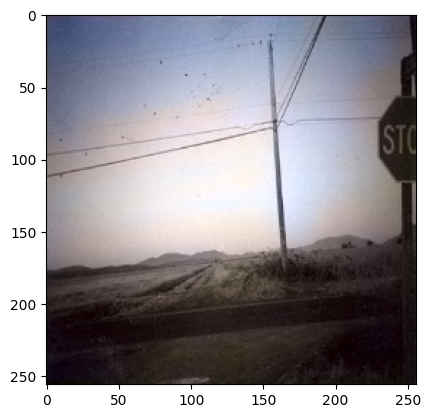

In [ ]:
plt.imshow(rst_auto[0])

### Pix2Pix GAN

In [ ]:
H, W = 256, 256

def sortImages(data):
    rule1 = lambda text: int(text) if text.isdigit() else text.lower()
    rule2 = lambda key: [rule1(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=rule2)
    
def imgArray(path, H=256, W=256):
    files = os.listdir(path)
    files = sortImages(files)

    imgs = []
    
    for i, img_name in tqdm(enumerate(files), total = len(files)):
        img = cv2.imread(path + img_name, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (H, W))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)        
        imgs.append(img)
    
    return imgs

imgs_c = imgArray(test_c)
imgs_b = imgArray(test_b)

imgs_c = tf.data.Dataset.from_tensor_slices(np.array(imgs_c)).batch(1)
imgs_b = tf.data.Dataset.from_tensor_slices(np.array(imgs_b)).batch(1)

rst_gan = []

for input, target in tf.data.Dataset.zip((imgs_b, imgs_c)):
    pred = gan(input, training=False)
    pred = np.squeeze(pred, axis=0)
    rst_gan.append(pred)

In [ ]:
# with open(path+'/rst_gan.pkl', 'wb') as f:
#     pickle.dump(rst_gan, f)

with open(path+'/rst_gan.pkl', 'rb') as f:
    rst_gan = pickle.load(f)

In [ ]:
plt.imshow(rst_gan[0])

### ChromeGAN

In [ ]:
chGAN_P = path + "/predict/ChromeGAN/"

'/content/drive/MyDrive/ColabNotebooks/DL_project/test_color/'

In [ ]:
H, W = 256, 256

def sortImages(data):
    rule1 = lambda text: int(text) if text.isdigit() else text.lower()
    rule2 = lambda key: [rule1(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=rule2)
    
def imgArray(path, H=256, W=256):
    files = os.listdir(path)
    files = sortImages(files)

    imgs = []
    
    for i, img_name in tqdm(enumerate(files), total = len(files)):
        img = cv2.imread(path + img_name, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (H, W))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)        
        imgs.append(img)
    
    return imgs

In [ ]:
rst_chgan = imgArray(chGAN_P)

100%|██████████| 739/739 [00:02<00:00, 253.34it/s]


In [ ]:
# with open(path+'/rst_chgan.pkl', 'wb') as f:
#     pickle.dump(rst_chgan, f)

with open(path+'/rst_chgan.pkl', 'rb') as f:
    rst_chgan = pickle.load(f)

In [ ]:
plt.imshow(rst_chgan[0])

# 4.2 Load Image Array & Save Image : jpg
- Save with JPG format

In [ ]:
# Load Image Array

with open(path+'/rst_CNN1.pkl', 'rb') as f:
    rst_CNN1 = pickle.load(f)

with open(path+'/rst_CNN2.pkl', 'rb') as f:
    rst_CNN2 = pickle.load(f)

with open(path+'/rst_auto.pkl', 'rb') as f:
    rst_auto = pickle.load(f)

with open(path+'/rst_gan.pkl', 'rb') as f:
    rst_gan = pickle.load(f)

In [ ]:
# For some reasons, all images save with this code are just black

# for i in range(len(rst_CNN1)):
#     cv2.imwrite(path+'/predict/VanillaCNN1/'+str(i)+'.jpg', rst_CNN1[i])

# for i in range(len(rst_CNN2)):
#     cv2.imwrite(path+'/predict/VanillaCNN2/'+str(i)+'.jpg', rst_CNN2[i])

# for i in range(len(rst_auto)):
#     cv2.imwrite(path+'/predict/Autoencoders/'+str(i)+'.jpg', rst_auto[i])

# for i in range(len(rst_gan)):
#     cv2.imwrite(path+'/predict/GAN/'+str(i)+'.jpg', rst_gan[i])

In [ ]:
for i in range(len(rst_CNN1)):
    plt.imshow(rst_CNN1[i])
    plt.savefig(path+'/predict/VanillaCNN1/'+str(i)+'.jpg')

In [ ]:
for i in range(len(rst_CNN2)):
    plt.imshow(rst_CNN2[i])
    plt.axis("off")
    plt.savefig(path+'/predict/VanillaCNN2/'+str(i)+'.jpg', bbox_inches="tight", pad_inches=0)

In [ ]:
for i in range(len(rst_auto)):
    plt.imshow(rst_auto[i])
    plt.axis("off")
    plt.savefig(path+'/predict/Autoencoders/'+str(i)+'.jpg', bbox_inches="tight", pad_inches=0)

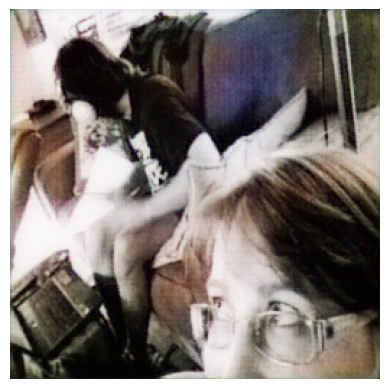

In [ ]:
for i in range(len(rst_gan)):
    plt.imshow(rst_gan[i])
    plt.axis("off")
    plt.savefig(path+'/predict/GAN/'+str(i)+'.jpg', bbox_inches="tight", pad_inches=0)

In [ ]:
print(rst_CNN1[0].shape, rst_CNN2[0].shape, rst_auto[0].shape, rst_gan[0].shape)

(224, 224, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


In [ ]:
for i in range(len(rst_CNN1)):
    rst_CNN1[i] = resize(rst_CNN1[i], (256, 256))

print(rst_CNN1[0].shape)

(256, 256, 3)


# 4.3 Quantitative Comparison

### Ground truth

In [ ]:
def sortImages(data):
    rule1 = lambda text: int(text) if text.isdigit() else text.lower()
    rule2 = lambda key: [rule1(c) for c in re.split('([0-9]+)',key)]
    return sorted(data, key=rule2)
    
def imgArray(path, H=256, W=256):
    files = os.listdir(path)
    files = sortImages(files)

    imgs = []
    
    for i, img_name in tqdm(enumerate(files), total = len(files)):
        img = cv2.imread(path + img_name, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (H, W))
        img = img.astype('float32') / 255.0
        img = img_to_array(img)        
        imgs.append(img)
    
    return imgs

imgs_c = imgArray(test_c)
imgs_b = imgArray(test_b)

print(len(imgs_c))
print(imgs_c[0].shape)

100%|██████████| 739/739 [00:17<00:00, 41.65it/s] 

739
(256, 256, 3)


### MSE : Mean Squared Error
- Lower MSE values indicate better performance

In [ ]:
def MSE(real, pred):
    
    rst = []
    for i in range(len(pred)):
        mse = np.mean((real[i] - pred[i]) ** 2)
        rst.append(mse)

    mse_avg = sum(rst) / len(rst)

    return rst, mse_avg

mse_CNN1_lst, mse_CNN1 = MSE(imgs_c, rst_CNN1)
mse_CNN2_lst, mse_CNN2 = MSE(imgs_c, rst_CNN2)
mse_auto_lst, mse_auto = MSE(imgs_c, rst_auto)
mse_gan_lst, mse_gan = MSE(imgs_c, rst_gan)

print(mse_CNN1, mse_CNN2, mse_auto, mse_gan)

0.12425583729704892 0.012339980364075891 0.008204060419020663 0.014118943834445454


In [ ]:
mse_chgan_lst, mse_chgan = MSE(imgs_c, rst_chgan)

print(mse_chgan)

0.007462259339633699


### PSNR
- measuring the quality of reconstructed or compressed images
- measures the ratio of the peak signal power to the noise power in the image
- A higher PSNR score indicates better image quality and lower noise levels in the image

In [ ]:
def PSNR(real, pred):

    rst = []
    for i in range(len(pred)):
        mse = np.mean((real[i] - pred[i]) ** 2)        # MSE between the two images
        max_pixel = 255.0                              # the maximum pixel value
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) # floating-point number
        rst.append(psnr)

    psnr_avg = sum(rst) / len(rst)

    return rst, psnr_avg

psnr_CNN1_lst, psnr_CNN1 = PSNR(imgs_c, rst_CNN1)
psnr_CNN2_lst, psnr_CNN2 = PSNR(imgs_c, rst_CNN2)
psnr_auto_lst, psnr_auto = PSNR(imgs_c, rst_auto)
psnr_gan_lst, psnr_gan = PSNR(imgs_c, rst_gan)
psnr_chgan_lst, psnr_chgan = PSNR(imgs_c, rst_chgan)

print(psnr_CNN1, psnr_CNN2, psnr_auto, psnr_gan, psnr_chgan)

57.2985130604321 68.62508856615057 70.55684038120164 67.74065348097237 70.70990600917862


### SSIM
- measures the similarity between two images in terms of their structural information
- It compares the luminance, contrast, and structure of the two images and generates a score between 0 and 1
- A higher SSIM score indicates higher similarity between the two images and better image quality

In [ ]:
def SSIM(real, pred):
    
    rst = []
    for i in range(len(pred)):
        s = ssim(real[i], pred[i], multichannel=True) # floating-point number
        rst.append(s)

    ssim_avg = sum(rst) / len(rst)

    return rst, ssim_avg

ssim_CNN1_lst, ssim_CNN1 = SSIM(imgs_c, rst_CNN1)
ssim_CNN2_lst, ssim_CNN2 = SSIM(imgs_c, rst_CNN2)
ssim_auto_lst, ssim_auto = SSIM(imgs_c, rst_auto)
ssim_gan_lst, ssim_gan = SSIM(imgs_c, rst_gan)
ssim_chgan_lst, ssim_chgan = SSIM(imgs_c, rst_chgan)

print(ssim_CNN1, ssim_CNN2, ssim_auto, ssim_gan, ssim_chgan)

<ipython-input-71-bd91f9a82ecf>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s = ssim(real[i], pred[i], multichannel=True) # floating-point number


0.2632665422433768 0.9154722545401814 0.9306263303401828 0.8290372377964738 0.8977328202559919


### LPIPS : Learned Perceptual Image Patch Similarity
- compute the similarity between two images
- compute the distance between the feature representations of the two images extracted by a pre-trained deep neural network
- A lower LPIPS score indicates higher similarity between the two images and better image quality

In [ ]:
def LPIPS(real, pred):

    rst = []

    for i in range(len(pred)):

        r = real[i].astype(np.float32)
        r = np.transpose(r, (2,0,1))
        r = np.expand_dims(r, axis=0)
        r = torch.from_numpy(r).to(torch.device('cuda'))

        p = pred[i].astype(np.float32)
        p = np.transpose(p, (2,0,1))
        p = np.expand_dims(p, axis=0)
        p = torch.from_numpy(p).to(torch.device('cuda'))

        lpips_model = lpips.LPIPS(net='vgg').to(torch.device('cuda'))

        lpips_dist = lpips_model(r, p).item()
        rst.append(lpips_dist)

    lpips_avg = sum(rst) / len(rst)
    
    return rst, lpips_avg

lpips_CNN1_lst, lpips_CNN1 = LPIPS(imgs_c, rst_CNN1)
lpips_CNN2_lst, lpips_CNN2 = LPIPS(imgs_c, rst_CNN2)
lpips_auto_lst, lpips_auto = LPIPS(imgs_c, rst_auto)
lpips_gan_lst, lpips_gan = LPIPS(imgs_c, rst_gan)

In [ ]:
lpips_chgan_lst, lpips_chgan = LPIPS(imgs_c, rst_chgan)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages

In [ ]:
print(lpips_CNN1, lpips_CNN2, lpips_auto, lpips_gan, lpips_chgan)

0.7022818307592679 0.1898429187289433 0.16334906575825767 0.33314473828217656 0.2007331932933953


### Colorfulness Metrics
- a measure of how vivid and intense the colors are in an image
- measures the variance of the pixel intensities in the color channels of the image
- It assumes that a more colorful image will have a higher variance in its color channels

In [ ]:
def COLORVAR(images):

    rst = []

    for i in range(len(images)):

        image = images[i]

        # Standard deviation of each color channel
        red_std = np.std(image[:,:,0])
        green_std = np.std(image[:,:,1])
        blue_std = np.std(image[:,:,2])
    
        # The average standard deviation
        avg_std = np.mean([red_std, green_std, blue_std])
    
        # The colorfulness as the square of the average standard deviation
        colorfulness = avg_std**2

        rst.append(colorfulness)

    avg = sum(rst)/len(rst)
    
    return rst, avg

color_CNN1_lst, color_CNN1 = COLORVAR(rst_CNN1)
color_CNN2_lst, color_CNN2 = COLORVAR(rst_CNN2)
color_auto_lst, color_auto = COLORVAR(rst_auto)
color_gan_lst, color_gan = COLORVAR(rst_gan)

print(color_CNN1, color_CNN2, color_auto, color_gan)

0.11410128874287177 0.058769422540374115 0.05625923899282519 0.05982944221089028


In [ ]:
color_chgan_lst, color_chgan = COLORVAR(rst_chgan)

print(color_chgan)

0.05493452587160648


# 4.4 Qualitative Comparison

In [ ]:
import cv2
from matplotlib import pyplot as plt

# pictures = [0, 2, 3, 10, 31, 37, 57, 59, 75, 84,
#             100, 150, 
#             298, 
#             449, 
#             567, 568, 570, 
#             600, 605, 610, 650, 660, 666, 680, 690, 693
#             700, 705, 707, 709, 710, 723, 738]

pictures = [10, 31, 57, 59, 84, 100, 449, 570, 605, 680, 690]

In [ ]:
size = (500, 500)

for i, pic in enumerate(pictures):

    num = 5000 + pic

    img_c = test_c + "image" + str(num) + ".jpg"
    cnn1 = path + "/predict/VanillaCNN1/" + str(pic) + ".jpg"    
    cnn2 = path + "/predict/VanillaCNN2/" + str(pic) + ".jpg"
    auto = path + "/predict/Autoencoders/" + str(pic) + ".jpg"
    gan  = path + "/predict/GAN/" + str(pic) + ".jpg"
    chgan  = path + "/predict/ChromaGAN/" + "image" + str(num) + ".jpg"

    img_c = Image.open(img_c).resize(size)
    cnn1 = Image.open(cnn1).resize(size)
    cnn2 = Image.open(cnn2).resize(size)
    auto = Image.open(auto).resize(size)
    gan = Image.open(gan).resize(size)
    chgan = Image.open(chgan).resize(size)

    title = ["Ground Truth", "Vanilla CNN1", "Vanilla CNN2", "Autoencoders", "Pix2Pix GANs", "Chroma GANs"]
    pics = [img_c, cnn1, cnn2, auto, gan, chgan]

    f, ax = plt.subplots(1,6, figsize=(15, 10))
    for j in range(6):
        if i == 0:
            ax[j].title.set_text(title[j])
        ax[j].axis('off')
        ax[j].imshow(pics[j])

    # ax[0].title.set_text("Ground Truth")
    # ax[1].title.set_text("Vanilla CNN1")
    # ax[2].title.set_text("Vanilla CNN2")
    # ax[3].title.set_text("Autoencoders")
    # ax[4].title.set_text("Pix2Pix GANs")
    # ax[5].title.set_text("Chroma GANs")
    # ax[0].axis('off')
    # ax[1].axis('off')
    # ax[2].axis('off')
    # ax[3].axis('off')
    # ax[4].axis('off')    
    # ax[5].axis('off')    
    # ax[0].imshow(img_c, aspect="equal")
    # ax[1].imshow(cnn1, aspect="equal")
    # ax[2].imshow(cnn2, aspect="equal")
    # ax[3].imshow(auto, aspect="equal")
    # ax[4].imshow(gan, aspect="equal")
    # ax[5].imshow(chgan, aspect="equal")

Output hidden; open in https://colab.research.google.com to view.